In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2.5e4: age_factor = 0.5
else: age_factor = 1.05

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Finance Junk,7.562165,0.945271,8
"CDK Global Ransomeware, June 2024",8.507094,0.850709,10
Azure AI Foundry,75.061206,15.012241,5
Dataverse,145.379902,72.689951,2
Diffusers Documentation,215.924780,71.974927,3
Azure AI Search,217.301159,72.433720,3
IW Migration,236.340831,8.440744,28
Email Auth and Security,242.837805,11.038082,22
Workera.ai,342.050834,68.410167,5
Git,350.957143,70.191429,5


18779.071074014682


<Axes: >

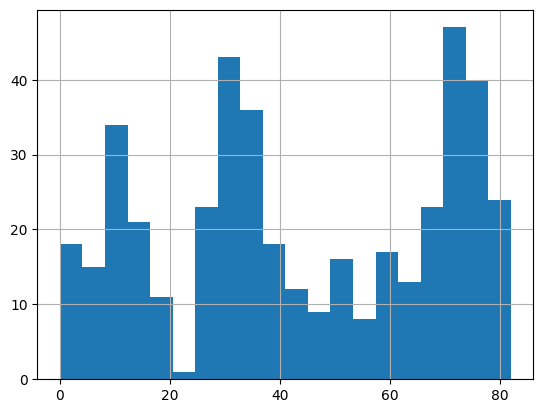

In [4]:
print(existing_cards['age'].sum())
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Headers with fewest notes first

In [7]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

Cards found: 429


In [8]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
1,Dataverse,MSAL (Microsoft Authentication Library):\n\nDe...,93220b9ee02cffefb5d859be13c52ef4,-72.816411,72.689951,-72.816411,145.379902,0.808489,2,72.816411
0,Dataverse,Public Client:\n\nDefinition: An application t...,dc1d3e9433efda233a156cd21b422839,-72.563491,72.689951,-72.816411,145.379902,0.808489,2,72.816411
2,Diffusers Documentation,The Stable Diffusion model is a good starting ...,eff6b91a6b52ad5e21804bab9cd3f529,-75.893089,71.974927,-75.893089,215.924780,0.476266,3,75.893089
3,Diffusers Documentation,The Scripts\ folder contains the pip executabl...,b4c635318e0167ffa9088203a64d7c4d,-70.377641,71.974927,-75.893089,215.924780,0.476266,3,75.893089
4,Diffusers Documentation,Choosing a more efficient scheduler could help...,329db08b8494c9d2dcea7e559d09c3cc,-69.654050,71.974927,-75.893089,215.924780,0.476266,3,75.893089
5,Azure AI Search,"Structured Data Integration: ""Mappings"" define...",df038957900e5fc2d352db08031b5786,-74.934321,72.433720,-74.934321,217.301159,0.771891,3,74.934321
6,Azure AI Search,Efficient Text Processing: The Text Split skil...,874caf7a81f89dd3ca5ddccfa16afae5,-71.235499,72.433720,-74.934321,217.301159,0.771891,3,74.934321
7,Azure AI Search,Detailed Diagnostic Insights: Debug Sessions o...,1134140a80c4e9a397c829d79d0abacd,-71.131340,72.433720,-74.934321,217.301159,0.771891,3,74.934321
8,Git,git status: This command shows the current sta...,92da3e212ca7c72115d05183ead08f9a,-78.587595,70.191429,-78.587595,350.957143,0.292112,5,78.587595
9,Git,git pull: This command fetches and integrates ...,87ce6a803e754c1046fac913f3bc567f,-73.914353,70.191429,-78.587595,350.957143,0.292112,5,78.587595


In [9]:
existing_cards['head'].value_counts()

Azure Kubernetes Learning Path       41
Home Network Project                 40
DNS                                  31
IW Migration                         28
Search Engine Optimization           25
Email Auth and Security              22
Python                               21
PP365                                18
sklearn                              17
Azure Functions                      17
OData                                17
Diffusers Library                    16
MS Identity Platform                 11
Power BI                             11
CDK Global Ransomeware, June 2024    10
Jane Eyre                            10
Diffusers from Hugging Face          10
Kali Linux                           10
Finance Junk                          8
AKS                                   8
pandas                                8
Dataverse Plugins                     7
Conditional Access                    7
Dataverse Queries                     7
Azure OpenAI                          6


# Focus on one header

In [10]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [11]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [12]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [13]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [14]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [15]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [16]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)